# Using XLuminA: 

In this notebook we show three examples of experiments that can be reproduced with XLuminA.

**(1) *Optical telescope (4F-correlator).***

**(2) *Polarization-based beam shaThe sharp focus for a radially polarized light beam.ping as used in STED.***

**(3) *The sharp focus for a radially polarized light beam.***

In [1]:
import os
import sys

# Setting the path for XLuminA modules:
current_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(current_path)

if module_path not in sys.path:
    sys.path.append(module_path)

## (1) Optical telescope (4F-correlator):

The 4F-correlator consists of two lenses (of focal lengths $f_1$ and $f_2$) each one positioned a focal length apart from their respective input and output planes and $f_1 + f_2$ from each other. This arrangement performs optical Fourier transformations of input light with magnifications determined by the ratio $f_2/f_1$. 

*We will code this system with a magnification of $2x$: in the input plane we place an object (mask) and we detect the inverted image of the object with twice its size.*

*We set: $f_1 = 15 mm$ and $f_2 = 30 mm$.*

In [2]:
from xlumina.__init__ import um, nm, mm, radians
from xlumina.wave_optics import *
from xlumina.optical_elements import lens
from xlumina.toolbox import space

2024-09-30 16:24:14.423988: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


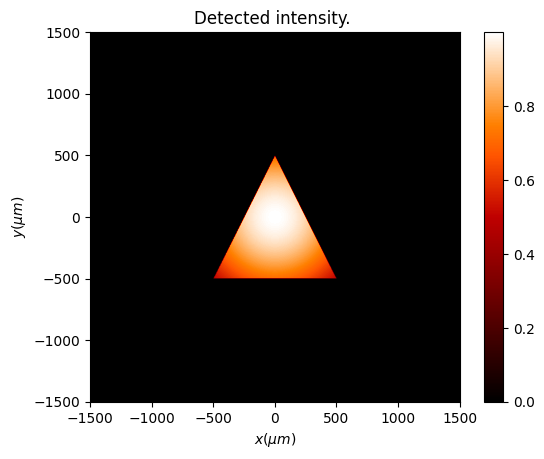

In [3]:
# System specs:
sensor_lateral_size = 1024  # Resolution
wavelength = 632.8*nm
x_total = 1500*um 
x, y = space(x_total, sensor_lateral_size)

# Light source: scalar field - gaussian beam
w0 = (1200*um , 1200*um)
gb = LightSource(x, y, wavelength)
gb.gaussian_beam(w0=w0, E0=1)

# Object (mask):
triangle = gb.apply_triangular_mask(r=(0, 250*um), angle=0*radians, m=2, height=1000*um) 
triangle.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

Time taken to perform one RS propagation (in seconds): 0.8444462139159441
Time taken to perform one RS propagation (in seconds): 0.003883376717567444
Time taken to perform one RS propagation (in seconds): 0.027769796550273895


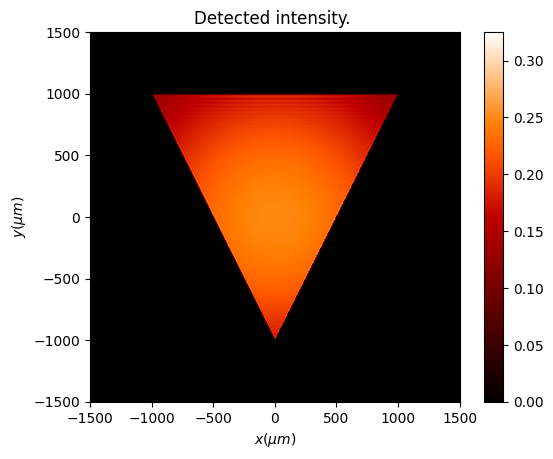

In [4]:
# Virtual setup: 
f_1 = 15*mm
f_2 = 30*mm
r = 5/2*mm

# 1. Propagate the light from the triangle a distance f_1:
triangle_f1, _ = triangle.RS_propagation(z=f_1)
# 2. Apply lens 1:
light_after_lens1, _ = lens(triangle_f1, radius=(r, r), focal=(f_1, f_1))

# 3. Propagate the light a distance f_1 + f_2:
triangle_f1f2, _ = light_after_lens1.RS_propagation(z=(f_1+f_2))

# 4. Apply lens 2:
light_after_lens2, _ = lens(triangle_f1f2, radius=(r, r), focal=(f_2, f_2))

# 5. Propagate the light a distance f_2:
detected_light, _ = light_after_lens2.RS_propagation(z=f_2)

# Plot the output:
detected_light.draw(xlim=(x[0], x[-1]), ylim=(y[0], y[-1]), kind='Intensity')

## (2) Polarization-based beam shaping as used in STED:

*The virtual setup in this example consists of two light sources generating Gaussian beams corresponding to the depletion and excitation beams with wavelengths of 650 nm and 532 nm, respectively. The excitation and depletion beams are linearly polarized in orthogonal directions. Within the depletionbeam’s optical path, we place an SLM with a spiral phase mask. After some propagation, we include a LCD device to ensure the circular polarization states in both beams. Afterwards, a high NA objective lens focuses the light onto the detector screen.*

***To simulate the basic concept of stimulated emission with neither time dependency nor fluorophores in the focal plane, we perform a subtraction of the intensity of the excitation and depletion beams, which results in the effective fluorescence that would ultimately be detected (negative values are set to zero, resembling a filter that removes residual depletion intensity***

In [5]:
from xlumina.__init__ import um, nm, mm, cm
from xlumina.vectorized_optics import *
from xlumina.optical_elements import sSLM, LCD, VCZT_objective_lens
from xlumina.toolbox import space, draw_sSLM
import jax.numpy as jnp

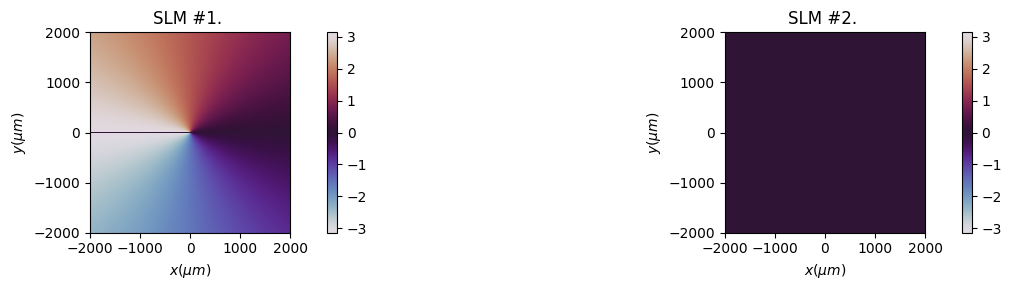

Minimum distance to propagate (in um): 23369.08622590808


In [6]:
# System specs:
sensor_lateral_size = 2048  # Resolution
depletion_wavelength = 650*nm
excitation_wavelength = 532*nm
x_total = 2000*um 
x, y = space(x_total, sensor_lateral_size)

# Light sources: orthogonally polarized excitation and depletion beams:
w0 = (1200*um , 1200*um)
depletion = PolarizedLightSource(x, y, depletion_wavelength)
depletion.gaussian_beam(w0=w0, jones_vector=(1, 0))
excitation = PolarizedLightSource(x, y, excitation_wavelength)
excitation.gaussian_beam(w0=w0, jones_vector=(0, 1))

# Define the high-resolution camera array:
x_out, y_out = jnp.array(space(10*um, 400)) # Pixel size detector: 50 nm = 0.05 um -> 20 um / 400 pix 

# Objective lens parameters:
NA = 0.9
radius_lens = 3.6*mm/2 
f_lens = radius_lens / NA

# Phase mask for SLM:
phase_mask = jnp.arctan2(depletion.Y,depletion.X)

# Draw SLM using sSLM drawing function (set SLM2 to zero):
extent_axis = [x[0], x[-1], y[0], y[-1]]
draw_sSLM(phase_mask, jnp.zeros((sensor_lateral_size, sensor_lateral_size)), extent=extent_axis, extra_title = '')

# Check minimum distance for VRS given sensor_lateral_size:
depletion.get_VRS_minimum_z()

In [7]:
# Optical setup: 

# 1. Apply phase mask to depletion beam. We use only the SLM in sSLM corresponding to the input polarization state. The other is set to zero.
depletion_modulated = sSLM(depletion, phase_mask, jnp.zeros((sensor_lateral_size, sensor_lateral_size)))
    
# 2. Propagate a distance a bit larger than '.get_VRS_minimum_z()':
depletion_propagated, _ = depletion_modulated.VRS_propagation(z=3*cm)
    
# 3. Convert linear states of polarization into circular via LCD (as quarter wave-plate):
depletion_cp = LCD(depletion_propagated, jnp.pi/2, jnp.pi/4)
excitation_cp = LCD(excitation, jnp.pi/2, jnp.pi/4)

# 4. Propagate excitation and depletion to focal plane and extract the intensity:
excitation_f = VCZT_objective_lens(excitation_cp, r=radius_lens, f=f_lens, xout=x_out, yout=y_out)
depletion_f = VCZT_objective_lens(depletion_cp, r=radius_lens, f=f_lens, xout=x_out, yout=y_out)

# 5. Compute STED-like function using radial intensities:
i_excitation = jnp.abs(excitation_f.Ex)**2 + jnp.abs(excitation_f.Ey)**2
i_depletion = jnp.abs(depletion_f.Ex)**2 + jnp.abs(depletion_f.Ey)**2
i_effective = jnp.clip(i_excitation - i_depletion, a_min=0, a_max=10e10)

Time taken to perform one VRS propagation (in seconds): 1.2671826146543026
Time taken to perform one VCZT propagation through objective lens (in seconds): 3.3513849899172783
Time taken to perform one VCZT propagation through objective lens (in seconds): 0.04531314969062805


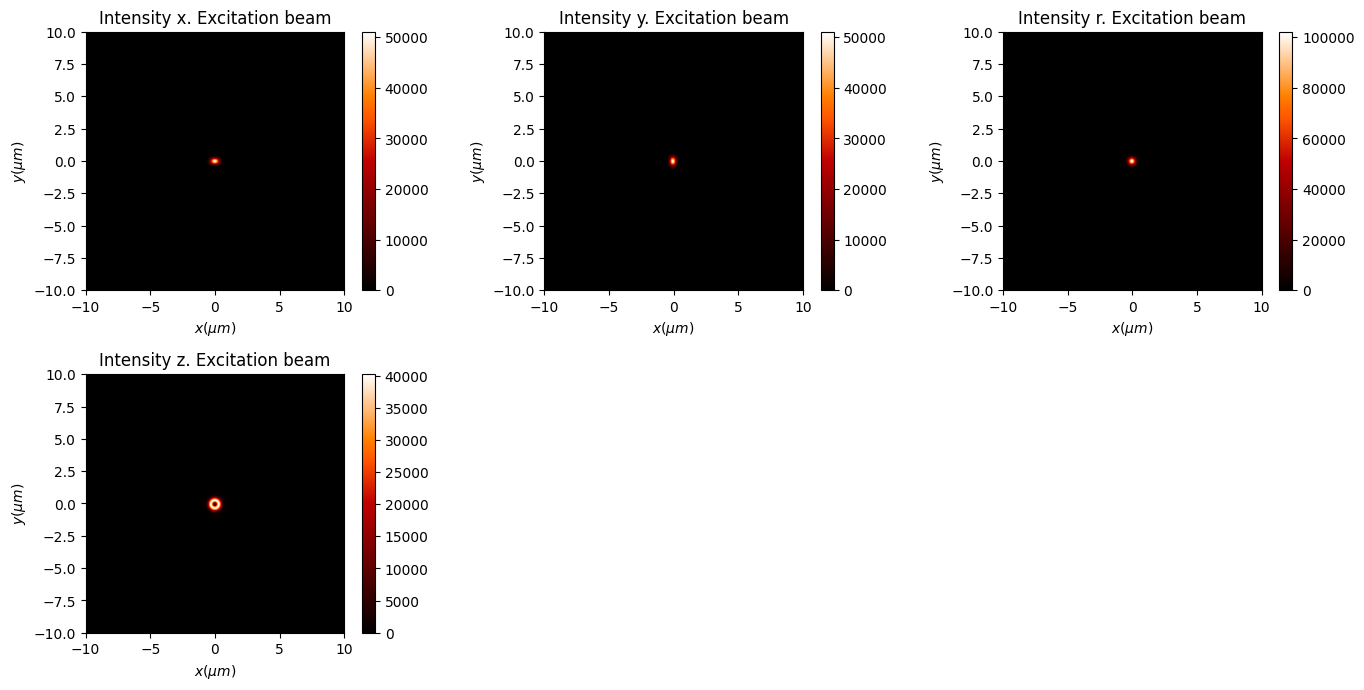

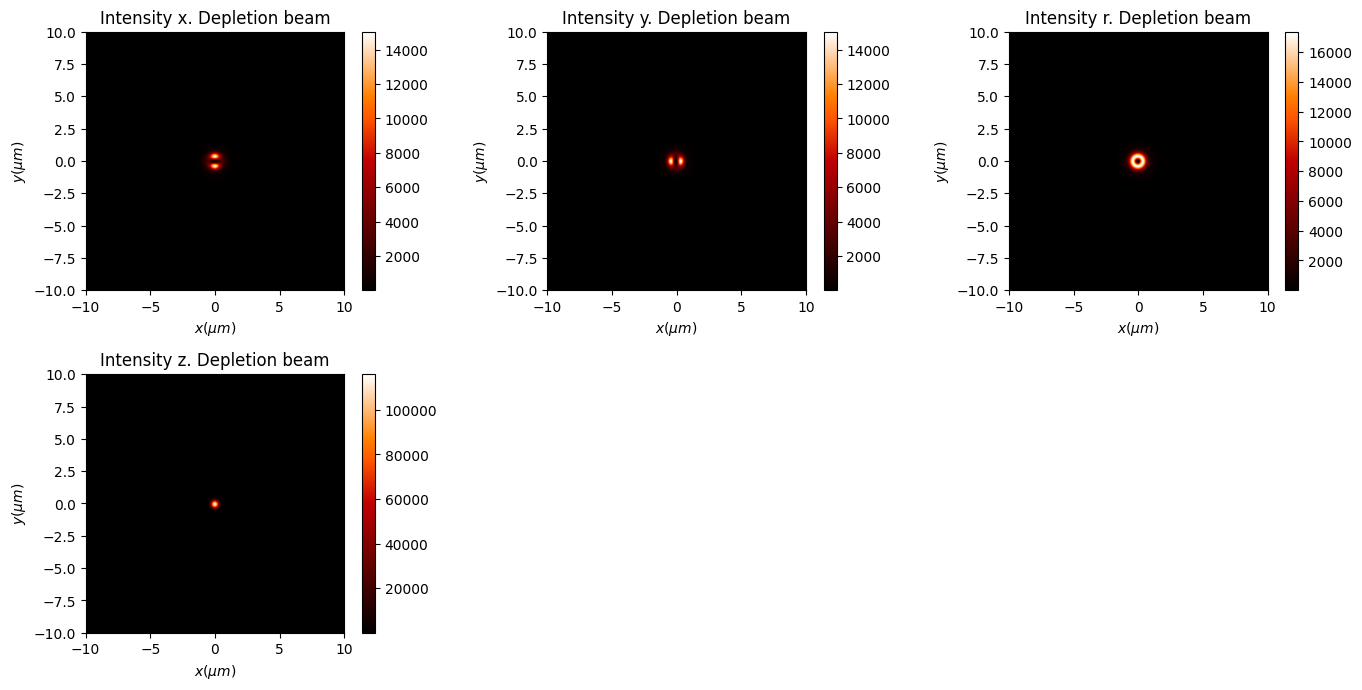

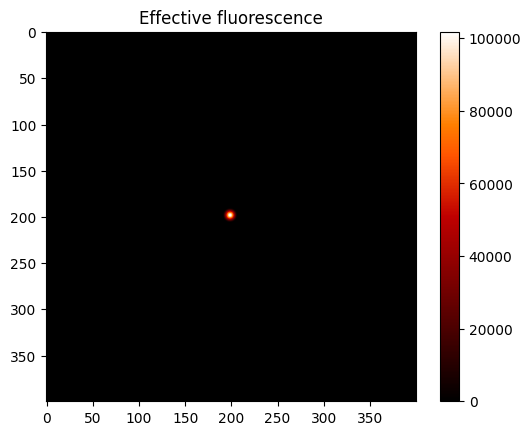

In [8]:
# Plot the intensity of excitation and depletion beams in the focal plane:
excitation_f.draw(xlim=(-10, 10), ylim=(-10, 10), kind='Intensity', extra_title='Excitation beam')
depletion_f.draw(xlim=(-10, 10), ylim=(-10, 10), kind='Intensity', extra_title='Depletion beam')

# Show effective intensity ("effective fluorescence"):
plt.imshow(i_effective, 'gist_heat')
plt.title('Effective fluorescence')
plt.colorbar()

## (3) The sharp focus for a radially polarized light beam:

*The virtual setup in this example consist of a light source emitting a 635 nm wavelength Gaussian beam that is linearly polarized. This beam interacts with an sSLM. Afterwards, the beam then passes through a high NA objective lens before reaching the detector screen.*

*This setup generates an ultra-sharp focus for a radially polarized beam, a feature that breaks the diffraction limit in the longitudinal direction ($E_z$). This super-resolution is achieved when a radially polarized beam is tightly focused using a high NA objective lens.*

*Importantly, by rotating the input polarization by 90 degrees (i.e., from `jones_vector=(1,1)` to `jones_vector=(-1,1)`) it is possible to switch from radially to azimuthally polarized beam while maintaining the same doughnut-shaped intensity distribution. In
the last case, however, the longitudinal electric field is zero at the optical axis*.

In [9]:
from xlumina.__init__ import um, nm, mm
from xlumina.vectorized_optics import *
from xlumina.optical_elements import sSLM, VCZT_objective_lens
from xlumina.toolbox import space, draw_sSLM
import jax.numpy as jnp

In [10]:
# System specs:
sensor_lateral_size = 2048  # Resolution
depletion_wavelength = 650*nm
excitation_wavelength = 532*nm
x_total = 1500*um 
x, y = space(x_total, sensor_lateral_size)

# Light source: linearly polarized gaussian beam (at 45 degrees).
w0 = (1200*um , 1200*um)
gb = PolarizedLightSource(x, y, depletion_wavelength)
gb.gaussian_beam(w0=w0, jones_vector=(1, 1))

# Define the high-resolution camera array:
x_out, y_out = jnp.array(space(10*um, 400)) # Pixel size detector: 50 nm = 0.05 um -> 20 um / 400 pix 

# Objective lens parameters:
NA = 0.9
radius_lens = 3.6*mm/2 
f_lens = radius_lens / NA

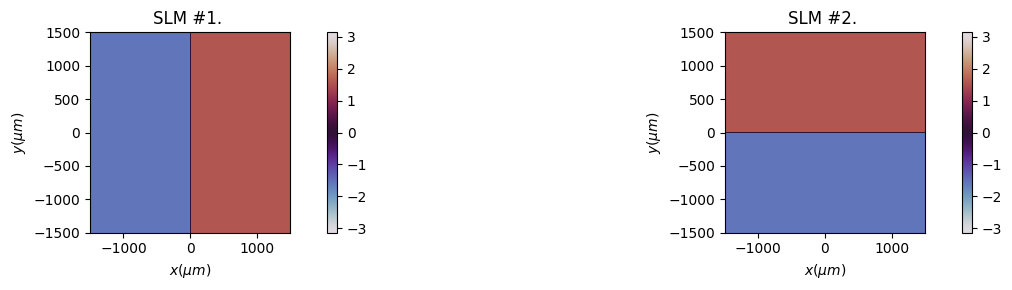

In [11]:
# Phase masks for sSLM:
pi_half = (jnp.pi - jnp.pi/2) * jnp.ones((sensor_lateral_size // 2, sensor_lateral_size // 2))
minus_pi_half = - jnp.pi/2 * jnp.ones((sensor_lateral_size // 2, sensor_lateral_size // 2))

# sSLM:
slm_1 = jnp.concatenate((jnp.concatenate((minus_pi_half, pi_half), axis=1), jnp.concatenate((minus_pi_half, pi_half), axis=1)), axis=0)
slm_2 = jnp.concatenate((jnp.concatenate((minus_pi_half, minus_pi_half), axis=1), jnp.concatenate((pi_half, pi_half), axis=1)), axis=0)

# Draw sSLM:
extent_axis = [x[0], x[-1], y[0], y[-1]]
draw_sSLM(slm_1, slm_2, extent=extent_axis, extra_title='')

In [12]:
# Optical setup:

# 1. Apply sSLM to input light:
modulated_light = sSLM(gb, slm_1, slm_2)

# Propagate:
propagated_light, _ = modulated_light.VRS_propagation(z=30*cm)

# Strong focus using microscope objective:
focused_light = VCZT_objective_lens(propagated_light, r=radius_lens, f=f_lens, xout=x_out, yout=y_out)

Time taken to perform one VRS propagation (in seconds): 0.3281692210584879
Time taken to perform one VCZT propagation through objective lens (in seconds): 0.09533640928566456


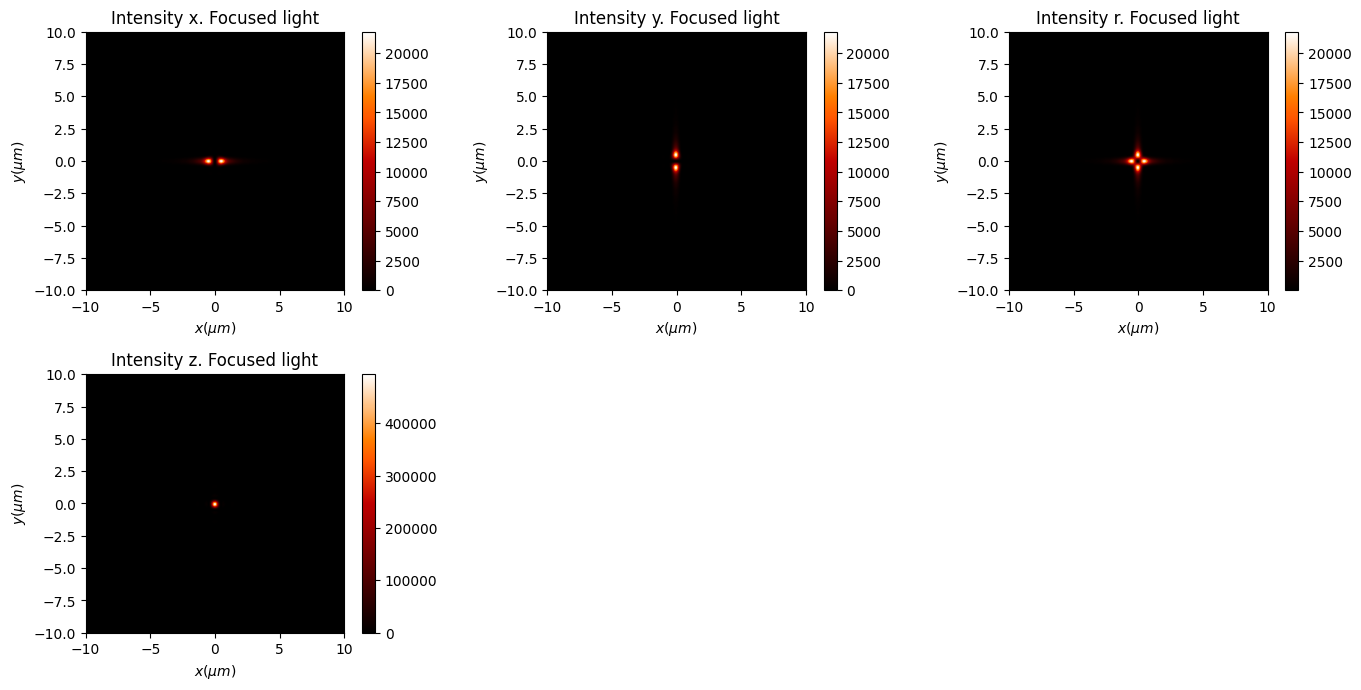

In [13]:
# Image the detected light:
focused_light.draw(xlim=(-10,10), ylim=(-10,10), kind='Intensity', extra_title ='Focused light')       